## Bayesian Calibration: Acceleration due to Gravity

To illustrate how to use XXX within YYY we will start with a very simple example of a falling ball example.

First, import the main libraries we use for this example:

In [1]:
import numpy as np
from scipy.stats import norm
from pyDOE import *
import scipy.optimize as spo
import sys
import os
from matplotlib import pyplot as plt

### Data: Acceleration due to Gravity

Let's read the real data first, and then visualize:

In [2]:
ball = np.loadtxt('ball.csv', delimiter=',')
n = len(ball)
#height
X = np.reshape(ball[:, 0], (n, 1))
#time
Y = np.reshape(ball[:, 1], ((n, 1)))

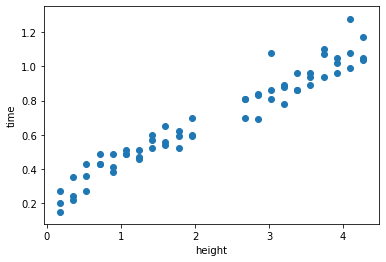

In [3]:
plt.scatter(X, Y)
plt.xlabel("height")
plt.ylabel("time")
plt.show()

### Computer model experiments

We know that $t = \sqrt{2h/g}$.

In [4]:
# Computer implementation of the mathematical model
def timedrop(x, theta, hr, gr):
    min_g = min(gr)
    range_g = max(gr) - min(gr)
    min_h = min(hr)
    range_h = max(hr) - min(hr)
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        g = range_g*theta[k] + min_g
        h = range_h*x + min(hr)
        f[k, :] = np.sqrt(2*h/g).reshape(x.shape[0])
    return f.T

Consider computer model emulator where $u \in [0, 30]$:

In [5]:
# Draw 100 random parameters from uniform prior
n2 = 100
theta = lhs(1, samples=n2)
theta_range = np.array([1, 30])

# Standardize 
height_range = np.array([min(X), max(X)])
X_std = (X[0:21] - min(X))/(max(X) - min(X))

# Obtain computer model output
Y_model = timedrop(X_std, theta, height_range, theta_range)

print(np.shape(theta))
print(np.shape(X_std))
print(np.shape(Y_model))

(100, 1)
(21, 1)
(21, 100)


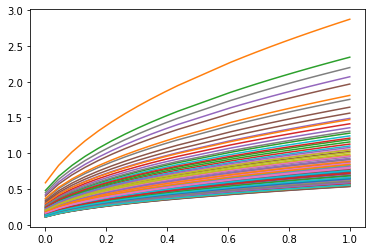

In [6]:
plt.plot(X_std, Y_model)
plt.show()

### Building an emulator via XXX

In [7]:
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator

#### Emulator without filtering

In [8]:
emulator_no_f = emulator(X_std, theta, Y_model, method = 'PCGPwM')

Let's observe the quality of an emulator without filtering:

In [9]:
#Predict
pred_model = emulator_no_f.predict(X_std, theta)
pred_mean = pred_model.mean()
print(np.shape(pred_mean))

(21, 100)


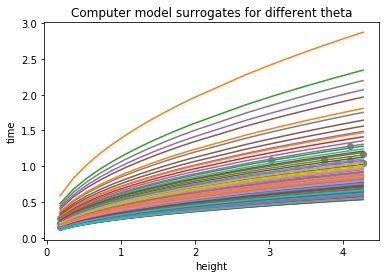

In [10]:
plt.scatter(X, Y, color = 'grey')
for i in range(np.shape(pred_mean)[1]):
    plt.plot(X[0:21], pred_mean[:, i])
plt.xlabel("height")
plt.ylabel("time")
plt.title("Computer model surrogates for different theta")
plt.show()

#### Emulator with filtering

(90, 1)
(21, 90)


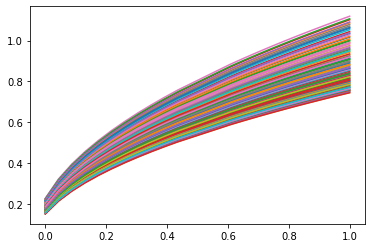

(21, 90)


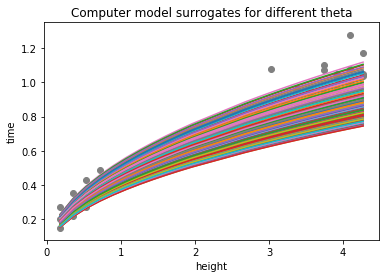

In [11]:
# Draw 50 random parameters from uniform prior
n2 = 300
theta_f = lhs(1, samples=n2)
theta_f = theta_f[(theta_f > 0.2) & (theta_f < 0.5)]
theta_f = theta_f.reshape(len(theta_f), 1)
theta_range = np.array([1, 30])
print(np.shape(theta_f))

# Obtain computer model output
Y_model = timedrop(X_std, theta_f, height_range, theta_range)
print(np.shape(Y_model))

plt.plot(X_std, Y_model)
plt.show()

emulator_f = emulator(X_std, theta_f, Y_model, method = 'PCGPwM')

pred_model = emulator_f.predict(X_std, theta_f)
pred_mean = pred_model.mean()
print(np.shape(pred_mean))

plt.scatter(X, Y, color = 'grey')
for i in range(np.shape(pred_mean)[1]):
    plt.plot(X[0:21], pred_mean[:, i])
plt.xlabel("height")
plt.ylabel("time")
plt.title("Computer model surrogates for different theta")
plt.show()

In [12]:
#Generate random reasonable theta values
theta_test = lhs(1, samples=1000)
theta_test = theta_test[(theta_test > 0.2) & (theta_test < 0.5)]
theta_test = theta_test.reshape(len(theta_test), 1)
theta_range = np.array([1, 30])
print(np.shape(theta_test))

# Obtain computer model output
Y_model_test = timedrop(X_std, theta_test, height_range, theta_range)
print(np.shape(Y_model_test))

#Predict
p_no_f = emulator_no_f.predict(X_std, theta_test)
pred_mean_no_f = p_no_f.mean()
p_f = emulator_f.predict(X_std, theta_test)
pred_mean_f = p_f.mean()

print(np.shape(pred_mean_no_f))
print(np.shape(pred_mean_f))

(300, 1)
(21, 300)
(21, 300)
(21, 300)


In [13]:
np.sum((pred_mean_no_f - Y_model_test)**2)

2.1930968836315885e-10

In [14]:
np.sum((pred_mean_f - Y_model_test)**2)

8.948540670891843e-06